# ASHRAE - Great Energy Predictor III
https://www.kaggle.com/competitions/ashrae-energy-prediction/overview

LightGBMをやってみる  
参考  
https://www.kaggle.com/code/aitude/ashrae-kfold-lightgbm-without-leak-1-08  

https://www.kaggle.com/code/patrick0302/locate-cities-according-weather-temperature/notebook

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261

LightGBM パラメーター内容  
https://zenn.dev/mosamosa/articles/07d0076c9292136a3639

In [4]:
# 定数定義
DATA_PATH = "./data"
""" データディレクトリ """

# メーターデータ 変換設定
CONVERT_METER_TYPE = 0
""" 変換対象メーター種別 """

CONVERT_METER_SITEID = 0
""" 変換対象サイトID """

CONVERT_METER_VALUE_COEF_BTU_TO_WAT = 0.2930711
""" メーター値変換係数(BTUからWAT) """

CONVERT_METER_VALUE_COEF_WAT_TO_BTU = 3.4121416
""" メーター値変換係数(WATからBTU) """


' メーター値変換係数(WATからBTU) '

In [6]:
# インポート定義

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
from dateutil import tz
import gc
import os
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

In [32]:
# データ読み込み
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

# Remove outliers
# TODO:なぜこの条件で除外しているかの確認が必要
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

building_df = pd.read_csv(os.path.join(DATA_PATH, 'building_metadata.csv'))
weather_df = pd.read_csv(os.path.join(DATA_PATH, 'weather_train.csv'))

In [7]:
def convert_meter_reading_btu_to_wh(df: pd.DataFrame) -> pd.DataFrame:
  """電力メーター値の単位をBTUからwhへ変換する

  Args:
      df (pd.DataFrame): 読み込みデータ

  Returns:
      pd.DataFrame: 電力メーター値をBTUからwhへ変換したデータ
  """

  # 対象データ抽出  
  target_data_df = df.query(f"site_id == {CONVERT_METER_SITEID} and meter == {CONVERT_METER_TYPE}")

  # 電力メーター量をkBTUから
  target_data_df.meter_reading = target_data_df.meter_reading * CONVERT_METER_VALUE_COEF_BTU_TO_WAT

  # データ更新
  df.update(target_data_df)

  return df

In [8]:
def convert_meter_reading_wh_to_btu(df: pd.DataFrame) -> pd.DataFrame:
  """電力メーター値の単位をwhからbtuへ変換する

  Args:
      df (pd.DataFrame): 読み込みデータ

  Returns:
      pd.DataFrame: 電力メーター値をwhからBTUへ変換したデータ
  """


  # 対象データ抽出  
  target_data_df = df.query(f"site_id == {CONVERT_METER_SITEID} and meter == {CONVERT_METER_TYPE}")

  # 電力メーター量をkBTUから
  target_data_df.meter_reading = target_data_df.meter_reading * CONVERT_METER_VALUE_COEF_WAT_TO_BTU

  # データ更新
  df.update(target_data_df)

  return df

In [17]:
def convert_timezone(weather_df: pd.DataFrame) -> pd.DataFrame:
  """気象データの観測日時をサイト毎の現地日時へ変換する

  Args:
      weather_df (pd.DataFrame): 気象データ

  Returns:
      pd.DataFrame: 観測日時のタイムゾーン変換後のデータを返す
  """
  # タイムゾーン定義
  UTC = tz.gettz("UTC") # 標準時
  EST = tz.gettz('EST') # 東部標準時
  EDT = tz.gettz('EDT') # 東部夏時間
  PST = tz.gettz('PST') # 太平洋標準時
  PDT = tz.gettz('PDT') # 太平洋夏時間
  CST = tz.gettz('CST') # 中部標準時
  CDT = tz.gettz('CDT') # 中部夏時間

  # タイムゾーン設定
  local_timezone_dict = {
    0: EST, # アメリカ フロリダ州 ジャクソンビル
    1: UTC, # イングランド ロンドン
    2: EST, # アメリカ フロリダ州 フェニックス
    3: EST, # アメリカ ペンシルベニア州 フィラデルフィア
    4: PST, # アメリカ カリフォルニア州 サンフランシスコ
    5: UTC, # イングランド ラフバラー
    6: EST, # アメリカ ペンシルベニア州 フィラデルフィア
    7: EST, # カナダ ケベック州 モントリオール
    8: EST, # アメリカ フロリダ州 ジャクソンビル
    9: CST, # アメリカ テキサス州 サンアントニオ
    10: PST, # アメリカ ネバダ州 ラスベガス
    11: EST, # カナダ ケベック州 モントリオール
    12: UTC, # アイルランド ダブリン
    13: CST, # アメリカ ミネソタ州 ミネアポリス
    14: EST, # アメリカ ペンシルベニア州 フィラデルフィア
    15: EST, # アメリカ ペンシルベニア州 ピッツバーグ
  }

  # サマータイムゾーン設定
  summer_timezone_dict = {
    0: EDT, # アメリカ フロリダ州 ジャクソンビル
    3: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
    4: PDT, # アメリカ カリフォルニア州 サンフランシスコ
    6: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
    7: EDT, # カナダ ケベック州 モントリオール
    8: EDT, # アメリカ フロリダ州 ジャクソンビル
    9: CDT, # アメリカ テキサス州 サンアントニオ
    10: PDT, # アメリカ ネバダ州 ラスベガス
    11: EDT, # カナダ ケベック州 モントリオール
    13: CDT, # アメリカ ミネソタ州 ミネアポリス
    14: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
    15: EDT, # アメリカ ペンシルベニア州 ピッツバーグ
  }

  # サマータイム 適用日時
  summer_time_start_timestamp = datetime.datetime(2016, 3, 12, 20, 0, 0, tzinfo=UTC)
  summer_time_end_timestamp = datetime.datetime(2016, 11, 5, 20, 0, 0, tzinfo=UTC)

  datetime_df = pd.DataFrame(data=weather_df, columns=["site_id", "timestamp"]) 
  datetime_df["datetime"] = pd.to_datetime(datetime_df["timestamp"], utc=True)
  datetime_df["original_datetime"] = datetime_df["datetime"]
  datetime_df["conv_timestamp"] = datetime_df["timestamp"]

  for siteId, timezone in local_timezone_dict.items():
    # タイムゾーン変換
    update_datetime_df = datetime_df[datetime_df["site_id"] == siteId]
    update_datetime_df["datetime"] = update_datetime_df["original_datetime"].dt.tz_convert(timezone)

    # 元の文字列フォーマットへ戻す
    update_datetime_df["conv_timestamp"] = update_datetime_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")

    # サマータイム変換 ※TODO:うまくいってない？
    if (siteId in summer_timezone_dict) :
      # タイムゾーン変換
      summer_timezone = summer_timezone_dict[siteId]
      summer_time_datetime_df = update_datetime_df[(update_datetime_df["original_datetime"] >= summer_time_start_timestamp) & (update_datetime_df["original_datetime"]  <= summer_time_end_timestamp)]
      summer_time_datetime_df["datetime"] = summer_time_datetime_df["original_datetime"].dt.tz_convert(summer_timezone)
      
      # 元の文字列フォーマットへ戻す
      summer_time_datetime_df["conv_timestamp"] = summer_time_datetime_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
      
      update_datetime_df.update(summer_time_datetime_df, overwrite=True)
    
    datetime_df.update(update_datetime_df, overwrite=True)
  
  datetime_df["timestamp"] = datetime_df["conv_timestamp"]
  datetime_df.drop(["datetime", "original_datetime", "conv_timestamp"], axis=1)

  weather_df.update(datetime_df, overwrite=True)
  return weather_df
  

In [18]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

def fill_weather_dataset(weather_df: pd.DataFrame) -> pd.DataFrame:
    """気象データの欠損値を補完する

    Args:
        weather_df (pd.DataFrame): 気象データ

    Returns:
        pd.DataFrame: データ補完後の気象データを返す
    """
    # サイトIDの数
    SITE_ID_COUNT = 16

    # 気象データの観測時間リストを作成
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    # サイト毎に欠損データを追加
    # ※追加するデータの値はnanを設定
    for site_id in range(SITE_ID_COUNT):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)

    # 観測日時より、日、週、月のカラムを作成
    # ※後述の追加カラムのため
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month

    # 欠損値を補完    
    # データ集計の高速化のため、集計単位でインデックスを作成
    weather_df = weather_df.set_index(['site_id','day','month'])

    # 気温
    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # 雲量
    # Step 1 グループ毎の平均値を取得
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2 直前に値が設定されている場合、その値を使用する
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    # 露点温度(≒湿度)
    dew_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(dew_temperature_filler, overwrite=False)

    # 海面気圧
    # Step 1 グループ毎の平均値を取得
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2 直前に値が設定されている場合、その値を使用する
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    # 風向き
    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    # 風速
    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # 降水量
    # Step 1 グループ毎の平均値を取得
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2 直前に値が設定されている場合、その値を資料する
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    # 観測日時を現地時間へ変換する
    # weather_df = convert_timezone(weather_df)

    # インデックスを再作成し、欠損値補完用に追加したカラムを削除
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)

    return weather_df

In [19]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

def reduce_mem_usage(df: pd.DataFrame, use_float16: bool = False) -> pd.DataFrame:
    """ロードしたデータを型変換し、容量を削減する

    Args:
        df (pd.DataFrame): ロードデータ
        use_float16 (bool, optional): float16使用フラグ デフォルト値：False

    Returns:
        pd.DataFrame: 容量削減後のデータを返す
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [20]:
def features_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """特徴量を作成する

    Args:
        df (pd.DataFrame): ロードしたデータ

    Returns:
        pd.DataFrame: 特徴量を追加したデータ
    """
    
    # 時系列順にソートする
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    # 日時
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    
    # 時間
    df["hour"] = df["timestamp"].dt.hour
    
    # 曜日
    df["weekend"] = df["timestamp"].dt.weekday
    
    # 総床面積 ※logでは0が設定された場合に-∞になるため、log(1+a)にする
    df["square_feet"] = np.log1p(df["square_feet"])

    # 築年数 ※値が設定されている場合は"1"、その他の場合は"0"を設定
    df["year_built"] = np.where(df["year_built"].notna(), 1, 0)

    # 体感温度 ※風による温度影響を測るため、北風をマイナス値(冷たい風)、南風をプラス値(暖かい風)とし、風速を掛けた値を設定する
    df["wind_direction"] = -np.sin(np.radians(df["wind_direction"] % 360))
    df["wind_warn"] = df["wind_direction"] * df["wind_speed"]
    
    # 使用しないカラムを削除する
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed", "floor_count", "building_id"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [33]:
# 気象データの欠損値を補完する
weather_df = fill_weather_dataset(weather_df)
weather_df = convert_timezone(weather_df)

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/4205743041.py:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  weather_df["week"] = weather_df["datetime"].dt.week
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/890867776.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  update_datetime_df["datetime"] = update_datetime_df["original_datetime"].dt.tz_convert(timezone)
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/890867776.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [34]:
# データ容量を削減する
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.18 MB
Decreased by 57.5%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.9%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.73 MB
Decreased by 71.7%


In [35]:
# コーディング用にロード、加工したデータを保存する
# TODO:テストコードのため、要削除
# train_df.to_pickle(os.path.join(DATA_PATH, "train_df.pkl"))
# building_df.to_pickle(os.path.join(DATA_PATH, "building_df.pkl"))
# weather_df.to_pickle(os.path.join(DATA_PATH, "weather_df.pkl"))
# weather_df.to_pickle(os.path.join(DATA_PATH, "weather_df2.pkl"))

In [21]:
# コーディング用に保存したデータをロードする
# TODO:テストコードのため、要削除
train_df = pd.read_pickle(os.path.join(DATA_PATH, "train_df.pkl"))
building_df = pd.read_pickle(os.path.join(DATA_PATH, "building_df.pkl"))
# weather_df = pd.read_pickle(os.path.join(DATA_PATH, "weather_df.pkl"))
weather_df = pd.read_pickle(os.path.join(DATA_PATH, "weather_df2.pkl"))

In [22]:
# 各データを結合する
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
# train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id', 'timestamp'])
train_df = train_df.merge(weather_df,how='inner',left_on=['site_id','timestamp'],right_on=['site_id', 'timestamp'])
del weather_df
gc.collect()

101

In [23]:
# 電力メーターの単位をwhに統一する
train_df = convert_meter_reading_btu_to_wh(train_df)

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_4020/3364352542.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_data_df.meter_reading = target_data_df.meter_reading * CONVERT_METER_VALUE_COEF_BTU_TO_WAT


In [24]:
# 特徴量を作成する
train_df = features_engineering(train_df)

In [25]:
# データを目的変数と特徴量変数に分割する
target = np.log1p(train_df["meter_reading"])
features = train_df.drop("meter_reading", axis = 1)
del train_df
gc.collect()

15

In [26]:
# カテゴリ変数リスト
categorical_features = ["site_id", "meter", "primary_use", "hour", "weekend", "year_built"]

# パラメーター設定
params = {
    "objective": "regression", # 目的関数：回帰
    "boosting": "gbdt", # 勾配ブースティング
    # "seed": 314, #シード値
    "num_leaves": 62, # 決定木の端末ノードの数
    #"max_depth": 7, #決定木の深さ
    "learning_rate": 0.05, # 学習率
    "feature_fraction": 0.85, # 特徴量の削減率 ※1未満の場合、特徴量を削減して学習される
    "reg_lambda": 2, # L2正則化項の係数 ※過学習を防ぐために用いる関数のパラメータ
    "metric": "rmse",# モデルの性能を測る指標 ※二乗平均平方根誤差
    "force_row_wise": True, # 行ベースのヒストグラムを生成する
    "verbose": -1
}

# シード値｀
seeds = [314, 2801, 3532]

earlyStoppingcallback = early_stopping(50)
logEvaluationCallback = log_evaluation(25)

# 学習実行
cnt = 0
kf = KFold(n_splits=3)
models = []
for train_index, test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]

    # データセット作成    
    d_training = lgb.Dataset(train_features, label=train_target, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target, free_raw_data=False)
    
    params["seed"] = seeds[cnt]

    # 学習実行
    model = lgb.train(
        params,
        train_set=d_training,
        num_boost_round=1000,
        valid_sets=[d_training, d_test],
        categorical_feature=categorical_features,
        callbacks=[
            earlyStoppingcallback,
            logEvaluationCallback
        ]
    )
    
    models.append(model)
    cnt += 1
    
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hour', 'meter', 'primary_use', 'site_id', 'weekend', 'year_built']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.56305	valid_1's rmse: 1.61777
[50]	training's rmse: 1.40081	valid_1's rmse: 1.45984
[75]	training's rmse: 1.32282	valid_1's rmse: 1.39184
[100]	training's rmse: 1.27852	valid_1's rmse: 1.35423
[125]	training's rmse: 1.24864	valid_1's rmse: 1.32993
[150]	training's rmse: 1.22192	valid_1's rmse: 1.30844
[175]	training's rmse: 1.19806	valid_1's rmse: 1.29085
[200]	training's rmse: 1.17771	valid_1's rmse: 1.27693
[225]	training's rmse: 1.15779	valid_1's rmse: 1.26557
[250]	training's rmse: 1.14064	valid_1's rmse: 1.25578
[275]	training's rmse: 1.1303	valid_1's rmse: 1.25082
[300]	training's rmse: 1.11887	valid_1's rmse: 1.2451
[325]	training's rmse: 1.10601	valid_1's rmse: 1.23767
[350]	training's rmse: 1.09329	valid_1's rmse: 1.22926
[375]	training's rmse: 1.08199	valid_1's rmse: 1.2238
[400]	training's rmse: 1.07192	valid_1's rmse: 1.21843
[425]	training's rmse: 1.06222	valid_1's rmse: 1.21351
[450]	trai

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hour', 'meter', 'primary_use', 'site_id', 'weekend', 'year_built']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[25]	training's rmse: 1.52081	valid_1's rmse: 1.607
[50]	training's rmse: 1.36975	valid_1's rmse: 1.487
[75]	training's rmse: 1.30026	valid_1's rmse: 1.4246
[100]	training's rmse: 1.25925	valid_1's rmse: 1.38431
[125]	training's rmse: 1.22991	valid_1's rmse: 1.36245
[150]	training's rmse: 1.20643	valid_1's rmse: 1.34102
[175]	training's rmse: 1.18786	valid_1's rmse: 1.32589
[200]	training's rmse: 1.1698	valid_1's rmse: 1.31187
[225]	training's rmse: 1.15513	valid_1's rmse: 1.29795
[250]	training's rmse: 1.13954	valid_1's rmse: 1.28207
[275]	training's rmse: 1.12643	valid_1's rmse: 1.26923
[300]	training's rmse: 1.11508	valid_1's rmse: 1.2559
[325]	training's rmse: 1.10877	valid_1's rmse: 1.25043
[350]	training's rmse: 1.0986	valid_1's rmse: 1.2395
[375]	training's rmse: 1.09058	valid_1's rmse: 1.23174
[400]	training's rmse: 1.08406	valid_1's rmse: 1.22571
[425]	training's rmse: 1.07681	valid_1's rmse: 1.21644
[450]	training's rmse: 1.06869	valid_1's rmse: 1.20811
[475]	training's rmse:

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hour', 'meter', 'primary_use', 'site_id', 'weekend', 'year_built']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[25]	training's rmse: 1.54796	valid_1's rmse: 1.56554
[50]	training's rmse: 1.40197	valid_1's rmse: 1.44114
[75]	training's rmse: 1.3233	valid_1's rmse: 1.38109
[100]	training's rmse: 1.27464	valid_1's rmse: 1.34694
[125]	training's rmse: 1.23797	valid_1's rmse: 1.32567
[150]	training's rmse: 1.20695	valid_1's rmse: 1.30712
[175]	training's rmse: 1.18193	valid_1's rmse: 1.29204
[200]	training's rmse: 1.15812	valid_1's rmse: 1.28215
[225]	training's rmse: 1.13914	valid_1's rmse: 1.272
[250]	training's rmse: 1.12402	valid_1's rmse: 1.26401
[275]	training's rmse: 1.10927	valid_1's rmse: 1.25614
[300]	training's rmse: 1.09705	valid_1's rmse: 1.25086
[325]	training's rmse: 1.08303	valid_1's rmse: 1.24438
[350]	training's rmse: 1.07153	valid_1's rmse: 1.24089
[375]	training's rmse: 1.06111	valid_1's rmse: 1.23606
[400]	training's rmse: 1.05177	valid_1's rmse: 1.2319
[425]	training's rmse: 1.04149	valid_1's rmse: 1.22766
[450]	training's rmse: 1.03084	valid_1's rmse: 1.22277
[475]	training's 

In [27]:
# メモリ解放
del features, target
gc.collect()

15

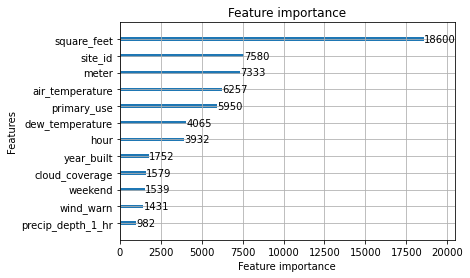

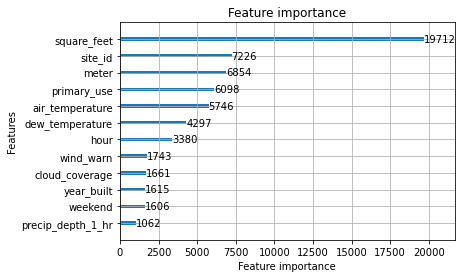

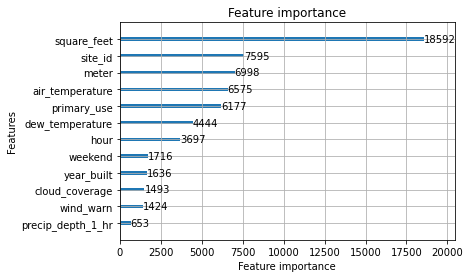

In [28]:
# 学習結果をプロット
for model in models:
    lgb.plot_importance(model)
    plt.show()
    # lgb.create_tree_digraph(model)

In [57]:
# テストデータ読み込み
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.47 MB
Decreased by 79.1%


In [58]:
# コーディング用にロード、加工したデータを保存する
# TODO:テストコードのため、要削除
# test_df.to_pickle(os.path.join(DATA_PATH, "test_df.pkl"))
# row_ids.to_pickle(os.path.join(DATA_PATH, "row_ids.pkl"))

In [59]:
# コーディング用に保存したデータをロードする
# TODO:テストコードのため、要削除
test_df = pd.read_pickle(os.path.join(DATA_PATH, "test_df.pkl"))
row_ids = pd.read_pickle(os.path.join(DATA_PATH, "row_ids.pkl"))

In [30]:
# ビルデータを結合
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
del building_df
gc.collect()

14879

In [43]:
# テスト気象データ読み込み、データを結合
weather_train_df = pd.read_csv(os.path.join(DATA_PATH, 'weather_train.csv'))
weather_test_df = pd.read_csv(os.path.join(DATA_PATH, 'weather_test.csv'))
weather_df = pd.concat([weather_train_df, weather_test_df])
# weather_df = pd.read_csv(os.path.join(DATA_PATH, 'weather_test.csv'))
weather_df = fill_weather_dataset(weather_df)
weather_df = convert_timezone(weather_df)
weather_df = reduce_mem_usage(weather_df)

del weather_train_df, weather_test_df

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/4205743041.py:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  weather_df["week"] = weather_df["datetime"].dt.week
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/890867776.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  update_datetime_df["datetime"] = update_datetime_df["original_datetime"].dt.tz_convert(timezone)
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/890867776.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Memory usage of dataframe is 28.90 MB
Memory usage after optimization is: 14.86 MB
Decreased by 48.6%


In [ ]:
# コーディング用にロード、加工したデータを保存する
# TODO:テストコードのため、要削除
# weather_df.to_pickle(os.path.join(DATA_PATH, "weather_test_df.pkl"))

In [31]:
# コーディング用に保存したデータをロードする
# TODO:テストコードのため、要削除
weather_df = pd.read_pickle(os.path.join(DATA_PATH, "weather_test_df.pkl"))

In [32]:
# 気象データをテストデータへ結合
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df
gc.collect()

0

In [35]:
# 特徴量を作成する
test_df = features_engineering(test_df)

In [54]:
# 推定する
results = []
for model in models:
    # 推定値の特定サイト、電力メーター量の単位を変換
    predicts = pd.Series(np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models), name="meter_reading")
    convert_df = pd.concat([test_df, predicts], axis=1)
    convert_df = convert_meter_reading_wh_to_btu(convert_df)

    # 推定結果を集計
    if  results == []:
        # results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
        results = convert_df.meter_reading.values / len(models)
    else:
        # results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
        results += convert_df.meter_reading.values / len(models)
    
    # del model
    del predicts, convert_df
    gc.collect()

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_4020/939704021.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_data_df.meter_reading = target_data_df.meter_reading * CONVERT_METER_VALUE_COEF_WAT_TO_BTU
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_4020/939704021.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_data_df.meter_reading = target_data_df.meter_reading * CONVERT_METER_VALUE_COEF_WAT_TO_BTU
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_402

In [55]:
# データ、モデル削除
del test_df, models
gc.collect()

15

In [60]:
# 提出データ作成
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
del row_ids,results
gc.collect()
results_df.to_csv("submission.csv", index=False)

In [62]:
results_df.head(20)

,row_id,meter_reading
0,0,34.018624
1,1,19.102110
2,2,6.484904
3,3,56.949119
4,4,288.589226
5,5,24.012328
6,6,40.783773
7,7,223.668535
8,8,121.291930
9,9,119.467165


In [64]:
# 推定結果を提出
!kaggle competitions submit  -f submission.csv -m "lightGBMを用いて推定 6回目提出 一部サイトの電力メーター値の単位変換処理を追加" ashrae-energy-prediction

100%|██████████████████████████████████████| 1.05G/1.05G [03:26<00:00, 5.46MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III

---

以下、テストコード

In [ ]:
# データ差異を確認
tmp_weather_df.merge(weather_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', 1)

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_19513/2116604713.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp_weather_df.merge(weather_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', 1)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
139773,1,2016-02-15 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139774,1,2016-02-15 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139775,1,2016-02-15 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139776,1,2016-02-15 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139777,1,2016-02-15 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
140539,15,2016-12-09 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140540,15,2016-12-17 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140541,15,2016-12-20 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140542,15,2016-12-24 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

np.log1p(0)

0.0

In [ ]:
# 風向きが0のデータは風速が0のデータであることを確認
weather_df.query("wind_direction == 0 and wind_speed != 0")

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [65]:
from matplotlib import pyplot

def plotMeterByYearBuilt(df: pd.DataFrame) -> None :
    """建築年とメーター値の散布図を作成する

    Args:
        df (pd.DataFrame): データ
    """
    
    fig, axes = pyplot.subplots(nrows=4, ncols=1, sharex=False)

    cnt = 0
    for ctg in [0, 1, 2 ,3]:
      plotDf = df.query(f"meter == {ctg}")
      axes[cnt].scatter(plotDf["year_built"], plotDf["meter_reading"])
      
      cnt += 1
      del plotDf
    
    fig.tight_layout()
    plt.show()


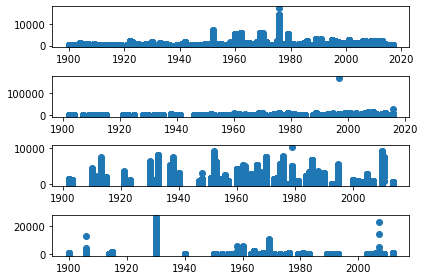

In [ ]:
# 建築年数は直接関係しない模様
plotMeterByYearBuilt(train_df)

In [69]:
from matplotlib import pyplot

def meterMeanByYearBuilt(df: pd.DataFrame) -> None :
    """メーター値の平均値を築年の設定有無毎に算出する

    Args:
        df (pd.DataFrame): データ
    """

    for ctg in [0, 1, 2 ,3]:
      yearBuiltSetDf = df.query(f"meter == {ctg} and year_built == year_built")
      yearBuiltNotSetDf = df.query(f"meter == {ctg} and year_built != year_built")

      yearBuiltSetMean =yearBuiltSetDf["meter_reading"].mean()
      yearBuiltNotSetMean =yearBuiltNotSetDf["meter_reading"].mean()

      print(f"Category: {ctg}")  
      print(f"YearBuiltSetMean: {yearBuiltSetMean}")  
      print(f"YearBuiltNotSetMean: {yearBuiltNotSetMean}")  
      
      del yearBuiltSetDf, yearBuiltNotSetDf, yearBuiltSetMean, yearBuiltNotSetMean
    

In [74]:
meterMeanByYearBuilt(train_df)

Category: 0
YearBuiltSetMean: 209.427490234375
YearBuiltNotSetMean: 148.044677734375
Category: 1
YearBuiltSetMean: 534.3399658203125
YearBuiltNotSetMean: 681.2288818359375
Category: 2
YearBuiltSetMean: 782.62548828125
YearBuiltNotSetMean: 1715.304931640625
Category: 3
YearBuiltSetMean: 186.57418823242188
YearBuiltNotSetMean: 547.9810180664062


In [75]:
from matplotlib import pyplot

def plotMeterByYearBuiltSet(df: pd.DataFrame) -> None :
    """建築年とメーター値の散布図を作成する

    Args:
        df (pd.DataFrame): データ
    """
    
    fig, axes = pyplot.subplots(nrows=4, ncols=2, sharex=False)

    cnt = 0
    for ctg in [0, 1, 2 ,3]:
      yearBuiltSetDf = df.query(f"meter == {ctg} and year_built == year_built")
      yearBuiltNotSetDf = df.query(f"meter == {ctg} and year_built != year_built")

      axes[cnt, 0].hist(yearBuiltSetDf["meter_reading"])
      axes[cnt, 1].hist(yearBuiltNotSetDf["meter_reading"])
      
      cnt += 1
      del yearBuiltSetDf, yearBuiltNotSetDf
    
    fig.tight_layout()
    plt.show()


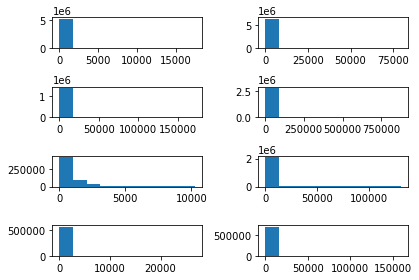

In [76]:
plotMeterByYearBuiltSet(train_df)

In [79]:
def meterStaticsByYearBuilt(df: pd.DataFrame) -> None :
    for ctg in [0, 1, 2 ,3]:
      yearBuiltSetDf = df.query(f"meter == {ctg} and year_built == year_built")
      yearBuiltNotSetDf = df.query(f"meter == {ctg} and year_built != year_built")
      print(f"Category: {ctg}")  
      print(f"YearBuiltSet")
      print(yearBuiltSetDf["meter_reading"].describe())
      print(f"YearBuiltNotSet")
      print(yearBuiltNotSetDf["meter_reading"].describe())
      
      del yearBuiltSetDf, yearBuiltNotSetDf
    

In [81]:
meterStaticsByYearBuilt(train_df)

Category: 0
YearBuiltSet
count    5.244763e+06
mean     2.094275e+02
std      4.735475e+02
min      0.000000e+00
25%      2.307000e+01
50%      7.810000e+01
75%      1.991750e+02
max      1.750210e+04
Name: meter_reading, dtype: float64
YearBuiltNotSet
count    6.461253e+06
mean     1.480447e+02
std      2.917258e+02
min      0.000000e+00
25%      2.131500e+01
50%      5.891670e+01
75%      1.553000e+02
max      7.976900e+04
Name: meter_reading, dtype: float64
Category: 1
YearBuiltSet
count    1.362881e+06
mean     5.343400e+02
std      1.216988e+03
min      0.000000e+00
25%      1.654710e+01
50%      1.074800e+02
75%      4.221040e+02
max      1.726110e+05
Name: meter_reading, dtype: float64
YearBuiltNotSet
count    2.819559e+06
mean     6.812289e+02
std      9.691904e+03
min      0.000000e+00
25%      7.631600e+00
50%      1.270000e+02
75%      4.833910e+02
max      8.803740e+05
Name: meter_reading, dtype: float64
Category: 2
YearBuiltSet
count    567697.000000
mean        782.625488

In [27]:
np.unique(train_df.site_id)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8)

In [94]:
# 標準時
UTC = tz.gettz("UTC")

# 東部標準時
EST = tz.gettz('EST')

# 東部夏時間
EDT = tz.gettz('EDT')

# 太平洋標準時
PST = tz.gettz('PST')

# 太平洋夏じかん
PDT = tz.gettz('PDT')

# 中部標準時
CST = tz.gettz('CST')

# 中部夏時間
CDT = tz.gettz('CDT')

# タイムゾーン設定
local_timezone_dict = {
  0: EST, # アメリカ フロリダ州 ジャクソンビル
  1: UTC, # イングランド ロンドン
  2: EST, # アメリカ フロリダ州 フェニックス
  3: EST, # アメリカ ペンシルベニア州 フィラデルフィア
  4: PST, # アメリカ カリフォルニア州 サンフランシスコ
  5: UTC, # イングランド ラフバラー
  6: EST, # アメリカ ペンシルベニア州 フィラデルフィア
  7: EST, # カナダ ケベック州 モントリオール
  8: EST, # アメリカ フロリダ州 ジャクソンビル
  9: CST, # アメリカ テキサス州 サンアントニオ
  10: PST, # アメリカ ネバダ州 ラスベガス
  11: EST, # カナダ ケベック州 モントリオール
  12: UTC, # アイルランド ダブリン
  13: CST, # アメリカ ミネソタ州 ミネアポリス
  14: EST, # アメリカ ペンシルベニア州 フィラデルフィア
  15: EST, # アメリカ ペンシルベニア州 ピッツバーグ
}

# サマータイムゾーン設定｀
summer_timezone_dict = {
  0: EDT, # アメリカ フロリダ州 ジャクソンビル
  3: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
  4: PDT, # アメリカ カリフォルニア州 サンフランシスコ
  6: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
  7: EDT, # カナダ ケベック州 モントリオール
  8: EDT, # アメリカ フロリダ州 ジャクソンビル
  9: CDT, # アメリカ テキサス州 サンアントニオ
  10: PDT, # アメリカ ネバダ州 ラスベガス
  11: EDT, # カナダ ケベック州 モントリオール
  13: CDT, # アメリカ ミネソタ州 ミネアポリス
  14: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
  15: EDT, # アメリカ ペンシルベニア州 ピッツバーグ
}

# サマータイム 適用日時
summer_time_start_timestamp = datetime(2016, 3, 12, 20, 0, 0, tzinfo=UTC)
summer_time_end_timestamp = datetime(2016, 11, 5, 20, 0, 0, tzinfo=UTC)

weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"], utc=True)
weather_df["original_datetime"] = weather_df["datetime"]
weather_df["conv_timestamp"] = weather_df["timestamp"]
datetime_df = pd.DataFrame(data=weather_df, columns=["site_id", "datetime", "original_datetime", "conv_timestamp"]) 

for siteId, timezone in local_timezone_dict.items():
  # タイムゾーン変換
  update_datetime_df = datetime_df[datetime_df["site_id"] == siteId]
  update_datetime_df["datetime"] = update_datetime_df["original_datetime"].dt.tz_convert(timezone)
  
  # 元の文字列フォーマットへ戻す
  update_datetime_df["conv_timestamp"] = update_datetime_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")

  
  # サマータイム変換
  if (siteId in summer_timezone_dict) :
    # タイムゾーン変換
    summer_timezone = summer_timezone_dict[siteId]
    summer_time_datetime_df = update_datetime_df[(update_datetime_df["original_datetime"] >= summer_time_start_timestamp) & (update_datetime_df["original_datetime"]  <= summer_time_end_timestamp)]
    summer_time_datetime_df["datetime"] = summer_time_datetime_df["original_datetime"].dt.tz_convert(summer_timezone)
    
    # 元の文字列フォーマットへ戻す
    summer_time_datetime_df["conv_timestamp"] = summer_time_datetime_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
    
    update_datetime_df.update(summer_time_datetime_df, overwrite=True)
  
  datetime_df.update(update_datetime_df, overwrite=True)

datetime_df["timestamp"] = datetime_df["conv_timestamp"]
datetime_df.drop(["site_id", "datetime", "original_datetime", "conv_timestamp"], axis=1)

weather_df.update(datetime_df)


/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_5037/614842603.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  update_datetime_df["datetime"] = update_datetime_df["original_datetime"].dt.tz_convert(timezone)
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_5037/614842603.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  update_datetime_df["conv_timestamp"] = update_datetime_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel

In [85]:
datetime_df[(datetime_df["original_datetime"] >= summer_time_start_timestamp) & (datetime_df["original_datetime"]  <= summer_time_end_timestamp)]

,site_id,datetime,original_datetime,conv_timestamp
1724,0.0,2016-03-12 15:00:00-05:00,2016-03-12 20:00:00+00:00,2016-03-12 15:00:00
1725,0.0,2016-03-12 16:00:00-05:00,2016-03-12 21:00:00+00:00,2016-03-12 16:00:00
1726,0.0,2016-03-12 17:00:00-05:00,2016-03-12 22:00:00+00:00,2016-03-12 17:00:00
1727,0.0,2016-03-12 18:00:00-05:00,2016-03-12 23:00:00+00:00,2016-03-12 18:00:00
1728,0.0,2016-03-12 19:00:00-05:00,2016-03-13 00:00:00+00:00,2016-03-12 19:00:00
...,...,...,...,...
140520,15.0,2016-11-02 08:00:00+00:00,2016-11-02 08:00:00+00:00,2016-11-02 08:00:00
140521,15.0,2016-11-02 09:00:00+00:00,2016-11-02 09:00:00+00:00,2016-11-02 09:00:00
140522,15.0,2016-11-02 10:00:00+00:00,2016-11-02 10:00:00+00:00,2016-11-02 10:00:00
140523,15.0,2016-11-03 03:00:00+00:00,2016-11-03 03:00:00+00:00,2016-11-03 03:00:00


In [67]:
print(update_datetime_df.replace())

0      2016-01-01 00:00:00+00:00
1      2016-01-01 01:00:00+00:00
2      2016-01-01 02:00:00+00:00
3      2016-01-01 03:00:00+00:00
4      2016-01-01 04:00:00+00:00
                  ...           
8779   2016-12-31 19:00:00+00:00
8780   2016-12-31 20:00:00+00:00
8781   2016-12-31 21:00:00+00:00
8782   2016-12-31 22:00:00+00:00
8783   2016-12-31 23:00:00+00:00
Name: datetime, Length: 8784, dtype: datetime64[ns, UTC]
